<a href="https://colab.research.google.com/github/zuzannasosnowska/Responsible-AI/blob/main/AI_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline


In [ ]:
# The variable names below defines the column names for both data files
names = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race','sex',
        'capital-gain','capital-loss','hours-per-week','native-country',
        'income']

#While reading the files data cleaning is also done as there are some values that contain " ?" 
#instead of data. Therefore they will be treated as NA values and later dropped
dataTrain = pd.read_csv(r"adult.csv",names=names,na_values=' ?')
dataTrain = dataTrain.dropna()

dataTest = pd.read_csv(r"adultTest.csv",names=names,na_values=' ?')
dataTest = dataTest.dropna()

In [ ]:
# Our target value is income but in order to do prediction the data has to be prepared and values 
# need to be changed into to binary results. Hence if persons income is >50K then the value will be 1
# and 0 otherwise 
dataTrain['income_binary'] = dataTrain.apply(lambda row: 1 if '>50K'in row['income'] else 0, axis=1)
dataTest['income_binary'] = dataTest.apply(lambda row: 1 if '>50K'in row['income'] else 0, axis=1)

#Since column income is no longer needed it can be dropped
dataTrain = dataTrain.drop(['income'], axis=1)
dataTest = dataTest.drop(['income'], axis=1)

#We will also drop some other columns on which the prediction will not be based. This is also due 
#to that for example 'fnlwgt' compared to 'workclass' does not have distinct values 
# and this could create some noise 
dataTrain = dataTrain.drop(['fnlwgt','capital-gain','capital-loss','native-country'], axis=1)
dataTest = dataTest.drop(['fnlwgt','capital-gain','capital-loss','native-country'], axis=1)

In [ ]:
#Now we will convert categorical variables into numerical by creating dummy variables.
# For example for each value in workclass there will be a separate column and if person matches 
# that workclass they will have 1 for value and 0 otherwise

dataTrain = pd.get_dummies(dataTrain, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
dataTest = pd.get_dummies(dataTest, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

In [ ]:
#Since we are already given seprate files for testing and training we will not use train_data_split 
# Instead we just separate the target variable (income_binary) and the predictor variables (age, education, etc.)
X_train = dataTrain.drop('income_binary', axis=1)
y_train = dataTrain['income_binary']
X_test = dataTest.drop('income_binary', axis=1)
y_test = dataTest['income_binary']

In [ ]:
#Now this code shows how the test data is being presented
X_test.head()

age  education-num  hours-per-week  workclass_ Federal-gov  \
1  25            7.0            40.0                       0   
2  38            9.0            50.0                       0   
3  28           12.0            40.0                       0   
4  44           10.0            40.0                       0   
6  34            6.0            30.0                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
1                     0                   1                        0   
2                     0                   1                        0   
3                     1                   0                        0   
4                     0                   1                        0   
6                     0                   1                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
1                            0                     0                       0   
2                            0                     0                       0   
3                            0                     0                       0   
4                            0                     0                       0   
6                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
1  ...                        1                        0                   0   
2  ...                        0                        0                   0   
3  ...                        0                        0                   0   
4  ...                        0                        0                   0   
6  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
1                         0                         0            1   
2                         0                         0            0   
3                         0                         0            0   
4                         0                         0            1   
6                         0                         0            0   

   race_ Other  race_ White  sex_ Female  sex_ Male  
1            0            0            0          1  
2            0            1            0          1  
3            0            1            0          1  
4            0            0            0          1  
6            0            1            0          1  

[5 rows x 60 columns]

# **Black-Box Technique**

In [ ]:
#For black-box technique I decided to use XGBoost
# We start first from fiting the model on train data 

xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

XGBClassifier(n_jobs=-1, random_state=33)

In [ ]:
X_test['age'] = pd.to_numeric(X_test['age'])

xgb_predictions = xgb.predict(X_test)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
#Now we will interpret this results using the confusion matrix and classification report
cm = confusion_matrix(y_test, xgb_predictions)
cr = classification_report(y_test, xgb_predictions)


print('Classification Report:')
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     11360
           1       0.71      0.56      0.63      3700

    accuracy                           0.84     15060
   macro avg       0.79      0.74      0.76     15060
weighted avg       0.83      0.84      0.83     15060



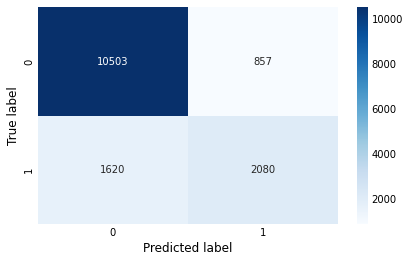

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The confusion matrix shows that the model correctly predicted 10503 instances as belonging to the negative class, income <=50K per year, and 2080 instances as belonging to the positive class, income >50K per year. However, the model incorrectly predicted 1620 instances as belonging to the positive class when they actually belonged to the negative class, and 857 instances as belonging to the negative class when they actually belonged to the positive class.

The precision for the negative class is 0.87, which means that out of all instances predicted as negative by the model, 87% of them actually belong to the negative class. The precision for the positive class is 0.71, which means that out of all instances predicted as positive by the model, 71% of them actually belong to the positive class.

The recall for the negative class is 0.92, which means that out of all instances that actually belong to the negative class, the model correctly identified 92% of them as negative. The recall for the positive class is 0.56, which means that out of all instances that actually belong to the positive class, the model correctly identified 56% of them as positive.

The F1-score for the negative class is 0.89, and the F1-score for the positive class is 0.63.

Overall, the model has an accuracy of 0.84, which means that it correctly classified 84% of the instances in the dataset. However, it has a higher precision and recall for the negative class than the positive class, indicating that the model is better at predicting instances that belong to the negative class than the positive class.

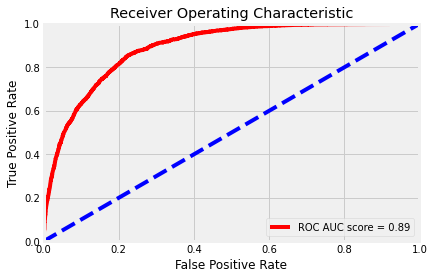

In [ ]:
# Now we will show the FPR and TPR for all thresholds of the classification
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

From this plot we can read that ROC AUC Score is 0.89 which is close to 1 which indicates that the model has a good measure of separability

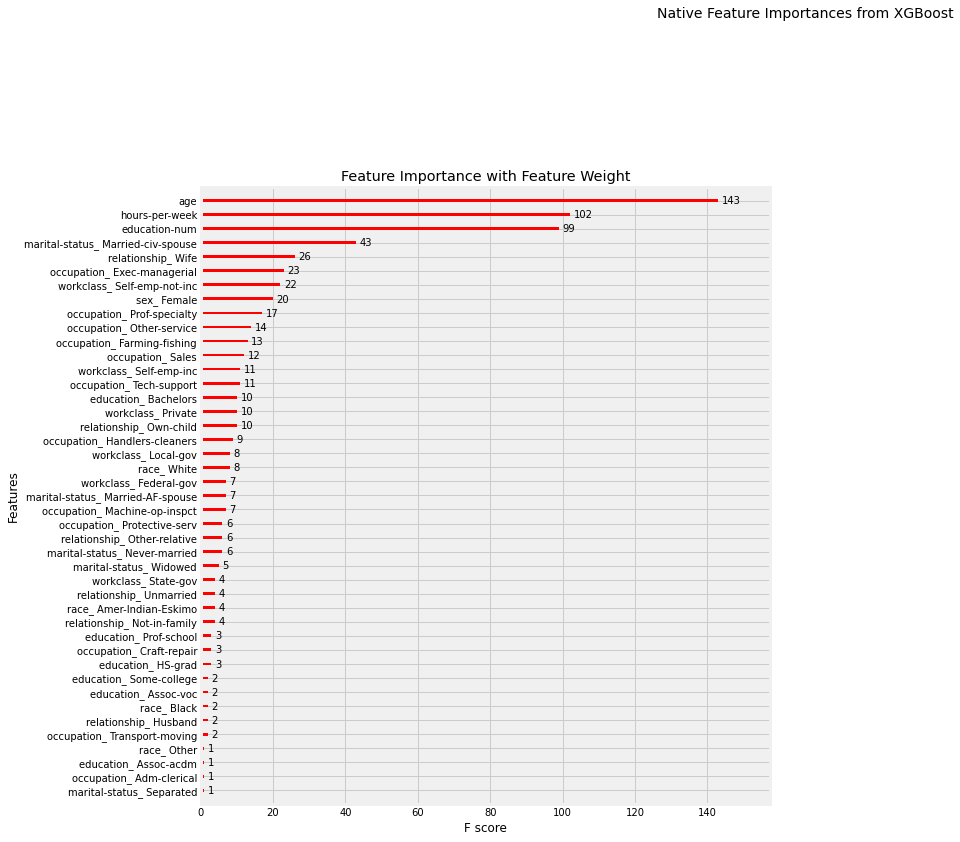

In [ ]:
# Now we will plot XGBoost default feature importances
fig = plt.figure(figsize = (20, 25))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");


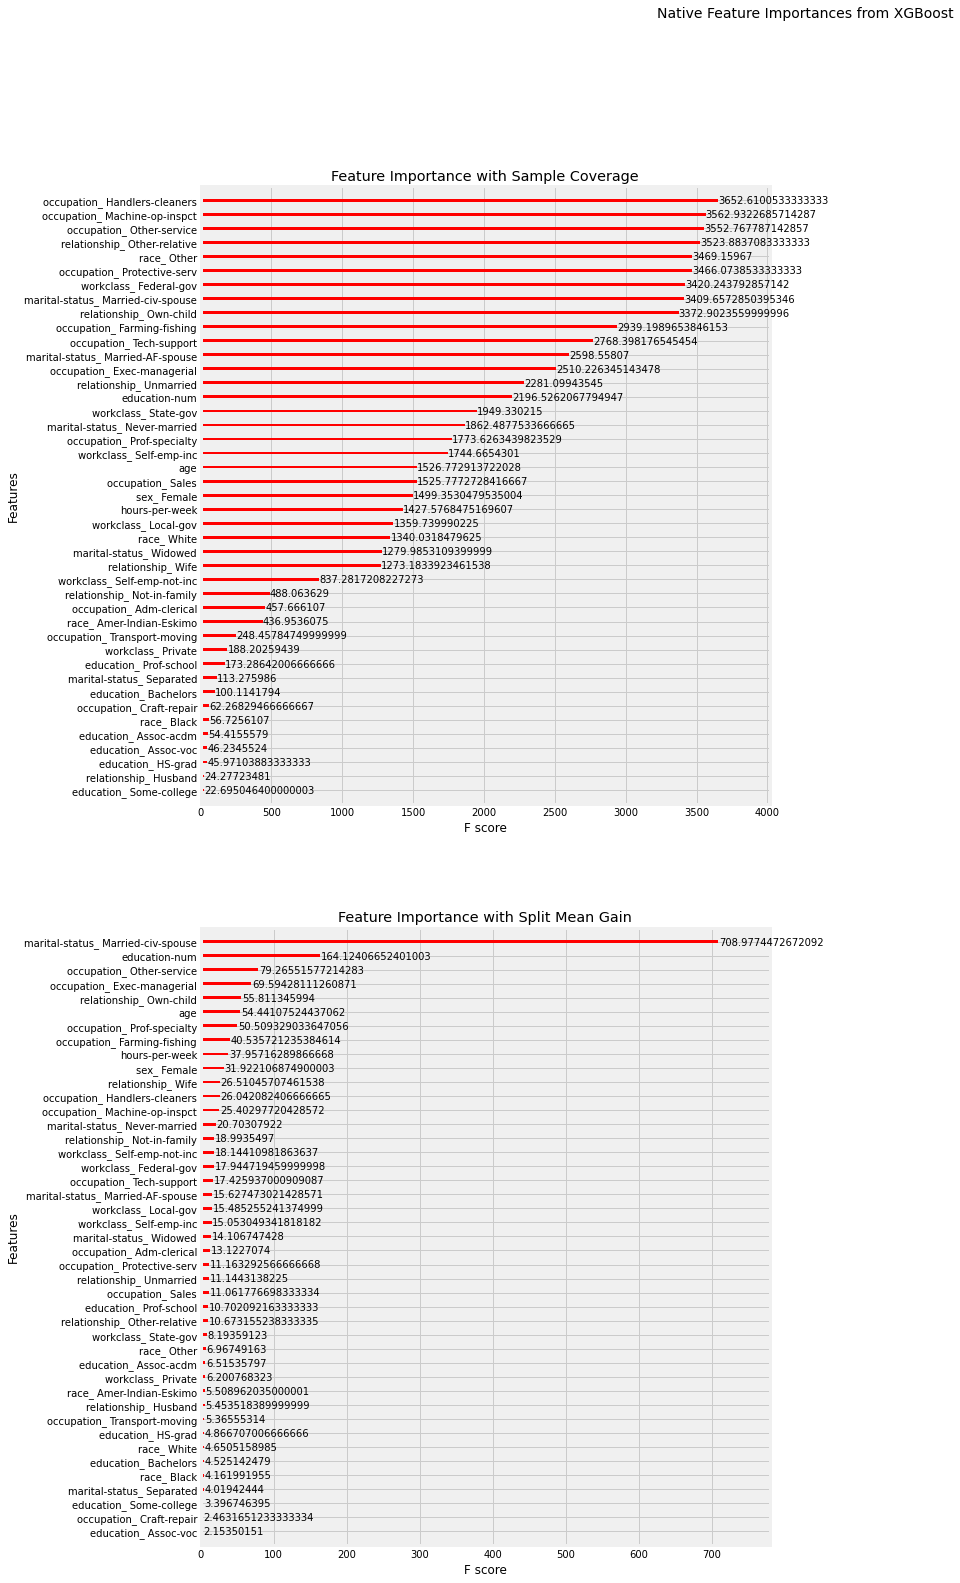

In [ ]:
fig = plt.figure(figsize = (20, 25))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)
ax2 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Feature Importance with Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Feature Importance with Split Mean Gain");

The first plot tells us that age, hours-per-week and education number had the highest values when compared to another features. This implies that they are more important for generating a prediction i.e., earning more than 50K.

Secondly, for the second plot that is based on the average number of samples affected of splits which use particular features, it was occupation_ Handlers-cleaners, occupation_ Machine-op-inspect and occupation_ Other-service that scored the highest. 

Lastly, the last plot bases on the average gain of splits which uses certain features. In this case it was marital_ Married-civ-spouse, education-num and occupation_ Other-service that had the highest results.

Hence it can be seen that features are ordered in differents ways by these different criterions. Therefore more analysis will be needed to get the full understatement. 

# **Interpretable Models - Decision Trees**

In [ ]:
#Optimising hyperparemeters for the small decision tree 

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# We define the range of potental hyperparameters to search
param_small = {'max_depth': [2, 5, 7, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5]}

# We create a decision tree classifier
dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_small, cv=5)
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best hyperparameters: ", best_params)
print("Best accuracy score: ",best_score)



Best hyperparameters:  {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best accuracy score:  0.8267359100543826


In [ ]:
# Now we will train a final decision tree model using the best hyperparameters on the full training data
dt_best_small = DecisionTreeClassifier(**best_params)
dt_best_small.fit(X_train, y_train)

pred_small= dt_best_small.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_small= accuracy_score(y_test,pred_small)
print(f'Accuracy: {accuracy_small} ')

Accuracy: 0.8293492695883135 


In [ ]:
#Now we will interpret this results using the confusion matrix and classification report
cm = confusion_matrix(pred_small,y_test)
cr = classification_report(pred_small,y_test)


print('Classification Report:')
print(cr)


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     11678
           1       0.61      0.67      0.64      3382

    accuracy                           0.83     15060
   macro avg       0.76      0.77      0.76     15060
weighted avg       0.84      0.83      0.83     15060



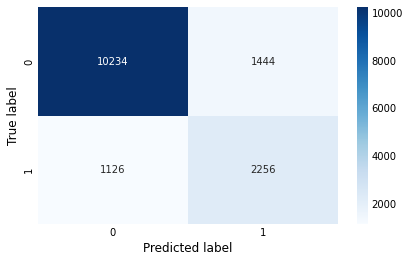

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The confusion matrix shows that the model correctly predicted 10234 instances as belonging to the negative class, income <=50K per year, and 2256 instances as belonging to the positive class, income >50K per year. However, the model incorrectly predicted 1126 instances as belonging to the positive class when they actually belonged to the negative class, and 1444 instances as belonging to the negative class when they actually belonged to the positive class.

The precision for the negative class is 0.90, which means that out of all instances predicted as negative by the model, 90% of them actually belong to the negative class. The precision for the positive class is 0.61, which means that out of all instances predicted as positive by the model, 61% of them actually belong to the positive class.

The recall for the negative class is 0.88, which means that out of all instances that actually belong to the negative class, the model correctly identified 88% of them as negative. The recall for the positive class is 0.67, which means that out of all instances that actually belong to the positive class, the model correctly identified 67% of them as positive.

The F1-score for the negative class is 0.89, and the F1-score for the positive class is 0.64.

Overall, the model has an accuracy of 0.83, which means that it correctly classified 83% of the instances in the dataset. However, it has a higher precision and recall for the negative class than the positive class, indicating that the model is better at predicting instances that belong to the negative class than the positive class.

In [ ]:
import graphviz

In [ ]:
from sklearn import tree

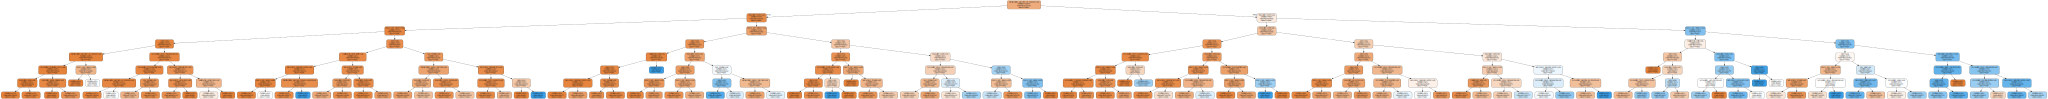

In [ ]:
# Now lets visualise the small tree to interpret this results 
dot_data = tree.export_graphviz(dt_best_small, out_file=None, label='all', impurity=False, proportion=True, 
                               feature_names=list(X_train), class_names=['<=50K', '>50K'],
                               filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph


From this graphic visualisation it can be read that class that is likely to earn more than 50K is represented by blue colours. From there the general conclusion is that features that played a role in this prediction was high hours per week (usually around 40h and more) and/or older age and/or being married and/or higher education level.

The orange part of the graph on the other hand represents prediction for earning less than 50K. In this case common features that pushed towards this predictions were lower education level and/or younger age and/or working less hours per week (usually less than 40h).

Now we will repeat actions but for large tree

In [ ]:
param_large = {'max_depth': [10, 20, 30],
              'min_samples_split': [50, 60, 70],
              'min_samples_leaf': [50, 60, 70]}
dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_large, cv=5)
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best hyperparameters: ", best_params)
print("Best accuracy score: ",best_score)



Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50}
Best accuracy score:  0.8292887735931599


In [ ]:
dt_best_large = DecisionTreeClassifier(**best_params)
dt_best_large.fit(X_train, y_train)

pred= dt_best_large.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_large= accuracy_score(y_test,pred)
print(f'Accuracy: {accuracy_large} ')

Accuracy: 0.8308764940239044 


In [ ]:
#Now we will interpret this results using the confusion matrix and classification report
cm = confusion_matrix(pred,y_test)
cr = classification_report(pred,y_test)


print('Classification Report:')
print(cr)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     11751
           1       0.60      0.67      0.64      3309

    accuracy                           0.83     15060
   macro avg       0.75      0.77      0.76     15060
weighted avg       0.84      0.83      0.83     15060



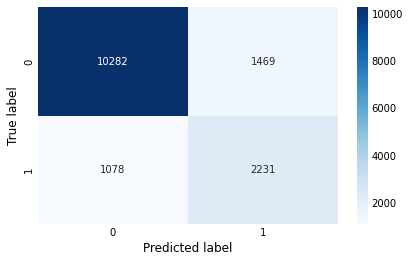

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The confusion matrix shows that the model correctly predicted 10282 instances as belonging to the negative class, income <=50K per year, and 2231 instances as belonging to the positive class, income >50K per year. However, the model incorrectly predicted 1078 instances as belonging to the positive class when they actually belonged to the negative class, and 1469 instances as belonging to the negative class when they actually belonged to the positive class.

The precision for the negative class is 0.91, which means that out of all instances predicted as negative by the model, 91% of them actually belong to the negative class. The precision for the positive class is 0.60, which means that out of all instances predicted as positive by the model, 60% of them actually belong to the positive class.

The recall for the negative class is 0.87, which means that out of all instances that actually belong to the negative class, the model correctly identified 87% of them as negative. The recall for the positive class is 0.67, which means that out of all instances that actually belong to the positive class, the model correctly identified 67% of them as positive.

The F1-score for the negative class is 0.89, and the F1-score for the positive class is 0.64.

Overall, the model has an accuracy of 0.83, which means that it correctly classified 83% of the instances in the dataset. However, it has a higher precision and recall for the negative class than the positive class, indicating that the model is better at predicting instances that belong to the negative class than the positive class.

Looking at the accuracy of these two modles tells us that the both trees scored the same value for the accuracy. Hence prediction of the income should be done with same precision.

Now if we would like to compare all these 3 models we can use a box plot for it

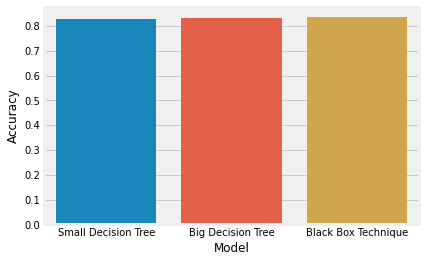

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
acuracy_black_box = np.round(metrics.accuracy_score(y_test, xgb_predictions), 4)
table = pd.DataFrame({
    'Model': ['Small Decision Tree', 'Big Decision Tree', 'Black Box Technique'],
    'Accuracy': [accuracy_small, accuracy_large, acuracy_black_box]
})

# Plot the performance of the models
sns.barplot(x='Model', y='Accuracy', data=table)
plt.show()

The bar plots tell us that all these models gave very similiar results as the differences in heights between them are really small. However it can be seen that that the best prediction was done by the black-box technique as it scored around 0.84 whereas decision trees scored 0.83

# Local Interpretability Framework 

In [ ]:
# For this we will use SHAP 
!pip install shap
import shap

# load JS visualization code to notebook
shap.initjs()

In [ ]:
# I will use SHAP to interpret the XGBoost result i.e., black-box technique 

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [ ]:
X_shap = pd.DataFrame(shap_values)
X_shap.tail()

0         1         2         3         4         5         6   \
15055 -0.137955  0.748042 -0.187241 -0.004604  0.005585 -0.000434 -0.006265   
15056  0.314177  0.654380 -0.148324 -0.005493  0.005597 -0.000404 -0.005935   
15057  0.208406  0.740133  0.338716 -0.006143  0.005597  0.002962 -0.007154   
15058  0.558468  0.675558 -0.168096 -0.006406  0.004238 -0.000240 -0.005935   
15059 -0.034939  0.780449  0.394066 -0.005744  0.004227 -0.003246  0.116293   

             7         8    9   ...        50        51        52        53  \
15055  0.008071  0.003105  0.0  ... -0.480296  0.000872 -0.034049  0.000207   
15056  0.014589  0.003105  0.0  ...  0.018229  0.005185 -0.039376  0.000207   
15057  0.023980  0.003105  0.0  ...  0.016271  0.002841 -0.028596  0.000207   
15058  0.016429  0.002236  0.0  ... -0.374015  0.000872 -0.029529  0.000207   
15059  0.046158  0.005180  0.0  ...  0.027522  0.002747 -0.022223  0.001319   

        54        55        56        57        58   59  
15055  0.0  0.000054  0.000177  0.005299  0.076974  0.0  
15056  0.0  0.000054  0.000378  0.005289 -0.234679  0.0  
15057  0.0  0.000054  0.000378  0.005299  0.045371  0.0  
15058  0.0  0.000054  0.000177 -0.043840  0.093076  0.0  
15059  0.0  0.000054  0.000378  0.005317  0.041785  0.0  

[5 rows x 60 columns]

In [ ]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  -1.2551552


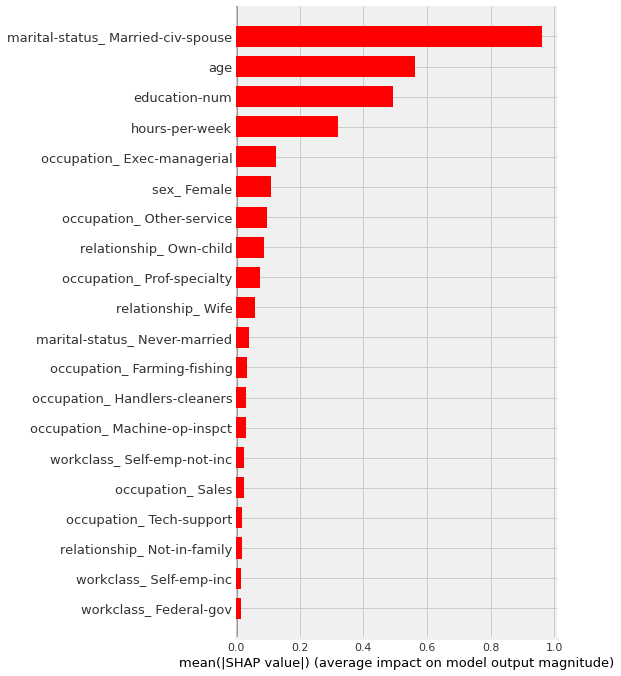

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')

From this summary plot it can be read that marrital-status_ Married-civ-spouse has the biggest average impact on the model output. Second is age and on the third place there is education-num feature.

*  Sample test 100 -> Most of them seem to be earning more than 50K. They are 
also married or\and  education-num = 14 or\and age = 49 or\and occupation_ Exec-managerial

* Sample test 300 -> Most of them seem to be earning less than 50K. They are not married or\and  education-num = 9 or\and age = 25

* Sample test around 500 -> Around 500 test samples there is an increase in people earning more than 50K and they have various features. Most dominant features seem to be high age and being married.

* Sample test around 700 -> Around 700 test samples there is an decrease and people are most likely be earning less than 50K and as before they have various features. Most dominant features seem to be low age and low education-num.

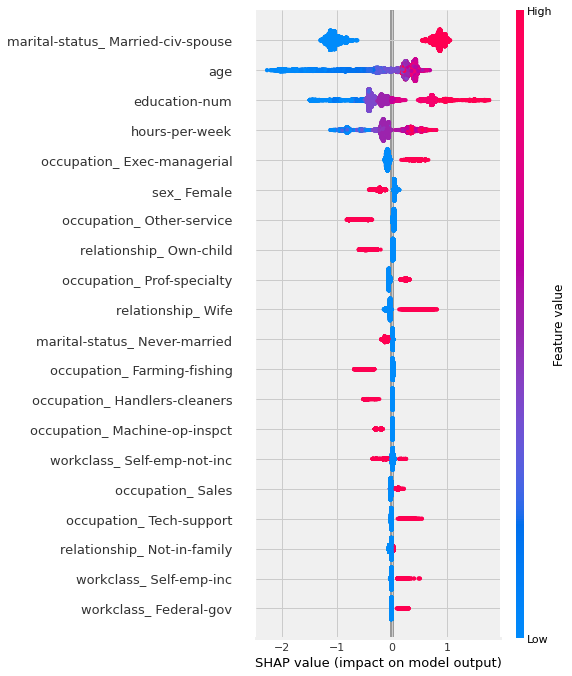

In [ ]:
shap.summary_plot(shap_values, X_test)

My hypthesis for the interpretation of this summary is that the education-num affects the model few predictions largely, whereas being married or age feture affects the whole by a smaller amount.

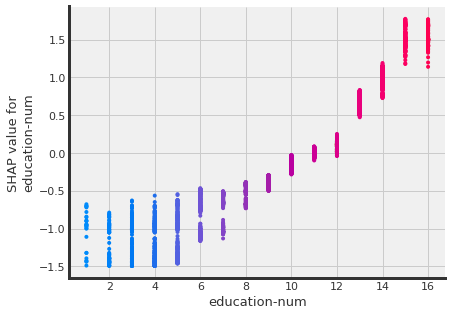

In [ ]:
shap.dependence_plot(ind='education-num', interaction_index='education-num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

This plot shows that with increasing education levels there is an increase in 
shap values. This makes model push towards thinking that people with higher education number make more money than people with lower education levels.

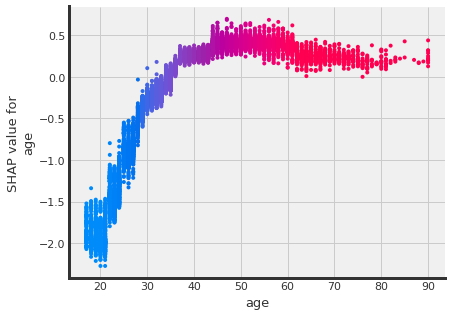

In [ ]:
shap.dependence_plot(ind='age', interaction_index='age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

This SHAP dependence plot confirms that the middle-aged people have a significantly higher shap value. This make model into to prediction that older people make more money as when compared with people that has less than 40 years

# Global Interpretability Framework

In [ ]:
!pip install pdpbox


In [ ]:
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

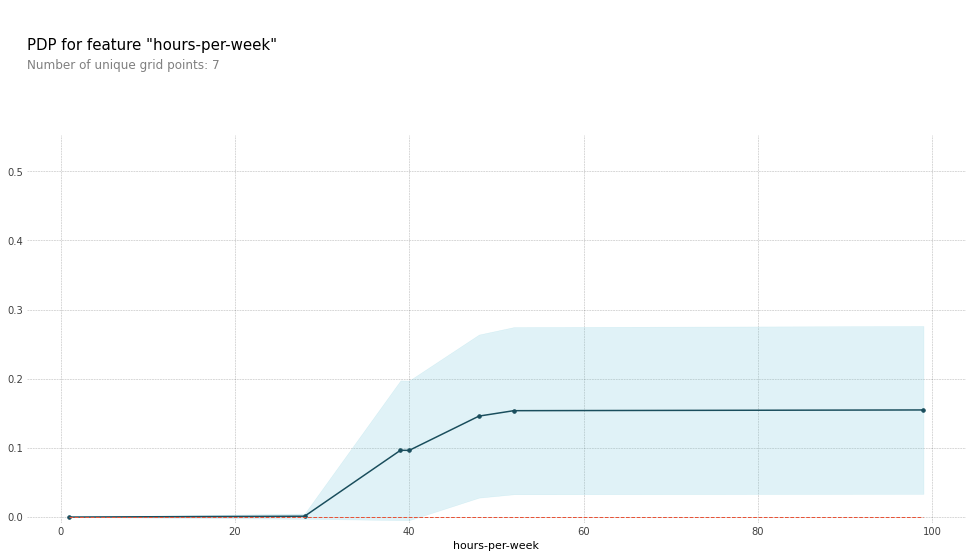

In [ ]:
plot_pdp(xgb, X_train, 'hours-per-week')

This partial dependence plot shows that with increase of working hours per week there is an increase in a chance to earn more than 50K.

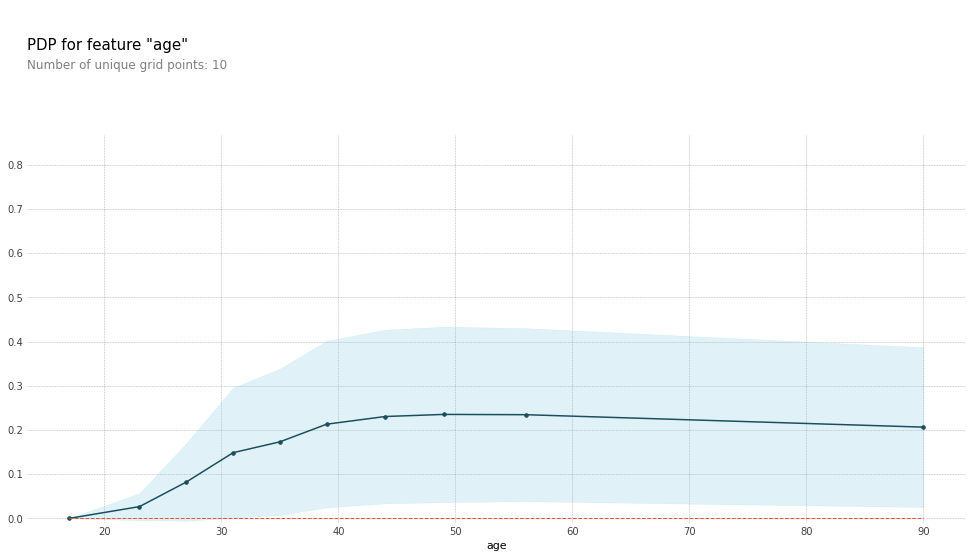

In [ ]:
plot_pdp(xgb, X_train, 'age')

This partial dependence plot confirms that the middle-aged people have a significantly higher values. This make model into to prediction that older people make more money as when compared with people that has less than 40 years

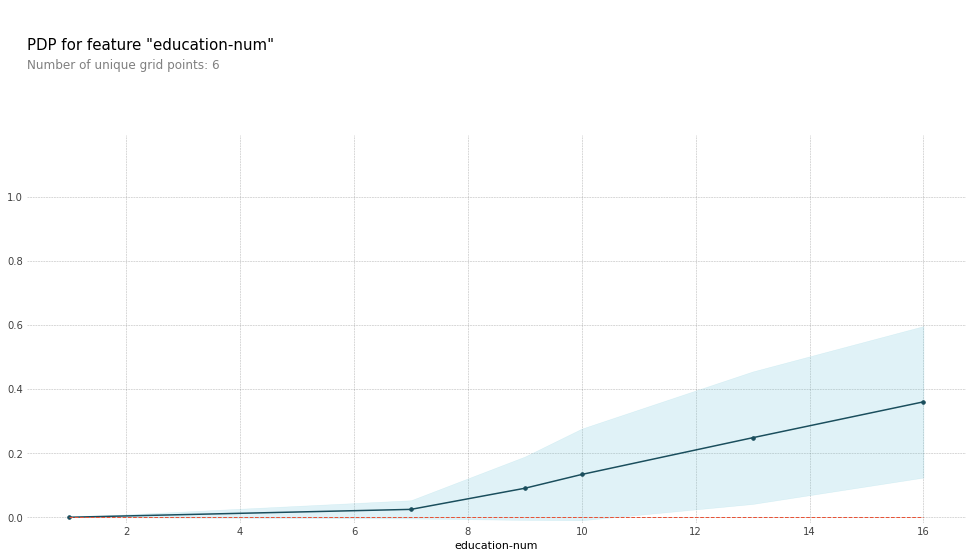

In [ ]:
plot_pdp(xgb, X_train, 'education-num')

This partial dependence plot shows that the higher the education number,then people are more likely to earn more than 50K.

# Comparision of results for the black-box model, PDP plots and the small decision tree

#TREE
From there the general conclusion is that features that played a role in this prediction was high hours per week  and/or older age and/or being married.

#BLACK BOX
The first plot tells us that age, hours-per-week and education number had the highest values when compared to another features. Secondly, for the plot that is based on the average number of samples affected of splits which use particular features, it was 3 certain occupations that scored the highest. 
Lastly, for the last plot it was marital_ Married-civ-spouse, once again education-num and occupation_ Other-service that had the highest results.

#GLOBAL INTERPRETABLE PLOT
This partial dependence plot showed that hours per week, being middle-aged person and having higher education level makes a person more  likely to earn more than 50K. 

When combined all these 3 interpretation it can be seen that there are some repetitions of features i.e.e, hours per week, being middle-aged person and having higher education which indicate to have the strongest impact on the model. 

# Error Analysis

(I decided to do the error anylysis manually as I had dificulties with accessing and using the recommended tool.)

In order to have the most precise analysis I will start from reading the train file again as I want to access preprocessed data. 

It is also worth mentioning that I will basing my analysis on train data as this is the source of models knowledge. Hence if biases are meant to be observed then they will be find there. 

In [ ]:
# The variable names below defines the column names for both data files
names = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race','sex',
        'capital-gain','capital-loss','hours-per-week','native-country',
        'income']

error_analysis = pd.read_csv(r"adult.csv",names=names,na_values=' ?')
error_analysis = error_analysis.dropna()

Text(0.5, 1.0, 'Race')

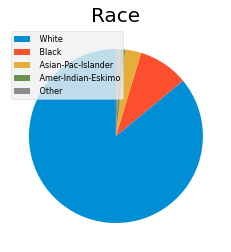

In [ ]:
counts = error_analysis['race'].value_counts()

labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=8)
plt.title("Race",size=20)

Text(0.5, 1.0, 'Sex')

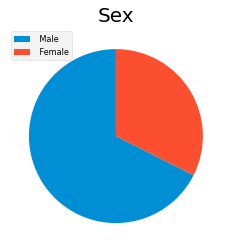

In [ ]:
counts = error_analysis['sex'].value_counts()

labels = counts.index

#Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=8)
plt.title("Sex",size=20)

In [ ]:
error_analysis.groupby(['marital-status', 'income']).size()

marital-status          income
 Divorced                <=50K    3762
                         >50K      452
 Married-AF-spouse       <=50K      11
                         >50K       10
 Married-civ-spouse      <=50K    7666
                         >50K     6399
 Married-spouse-absent   <=50K     339
                         >50K       31
 Never-married           <=50K    9256
                         >50K      470
 Separated               <=50K     873
                         >50K       66
 Widowed                 <=50K     747
                         >50K       80
dtype: int64

In [ ]:
error_analysis.groupby(['sex', 'income']).size()

sex      income
 Female   <=50K     8670
          >50K      1112
 Male     <=50K    13984
          >50K      6396
dtype: int64

In [ ]:
error_analysis.groupby(['race', 'income']).size()

race                 income
 Amer-Indian-Eskimo   <=50K      252
                      >50K        34
 Asian-Pac-Islander   <=50K      647
                      >50K       248
 Black                <=50K     2451
                      >50K       366
 Other                <=50K      210
                      >50K        21
 White                <=50K    19094
                      >50K      6839
dtype: int64

In [ ]:
error_analysis.groupby(['education']).size()


education
 10th             820
 11th            1048
 12th             377
 1st-4th          151
 5th-6th          288
 7th-8th          557
 9th              455
 Assoc-acdm      1008
 Assoc-voc       1307
 Bachelors       5044
 Doctorate        375
 HS-grad         9840
 Masters         1627
 Preschool         45
 Prof-school      542
 Some-college    6678
dtype: int64

By starting the analysis from count of each race it can be seen that this dataset does not contain even numbers of people representing chosen races as it is dominated by white race. This can affect  model in being more biased towards them as it had less data about which later  can affect the accuracy of prediction. It could learn that is only mostly likely for white people earn more than 50K than for any other race. 

Secondly, the results shows that the dataset contains more males than females (13984 males; 8670 females). The number of males earning over 50K is much higher than the number of females earning over 50K (6396 males compared to 1112 females. 

This can be once again push prediction towards being potentially biased against females, which could be due to larger sample of men that took part in this and/or due to the fact that this data was done in 1994 when it was more likely for men to earn more than woman. 

Looking at the marital status and the income shows that individuals who are married-civ-spouse have the highest count for both less than 50K and greater then 50K incomes. This suggests that being married-civ-spouse may have some correlation with higher income levels.

Although, the category of those who never been married has the highest count for the less than 50k income category and a relatively low count for the greater than 50K income category. Hence this raises suggestion that being unmarried may have some correlation with lower income.

Moreover, the education distribution results show this feature may also affect the model's bias towards certain groups. For instance, if the majority of the people in the dataset have a high school diploma or higher education, the model may not perform as well for people with lower levels of education, as there are fewer data points to learn from in those groups. 


In [ ]:
sex = ['Female', 'Male']
for gender in sex:
    idx = X_test[f'sex_ {gender}'] == 1
    cm = confusion_matrix(y_test[idx], xgb_predictions[idx])
    cr = classification_report(y_test[idx], xgb_predictions[idx])
    print(f'{gender}:')
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(cr)

Female:
Confusion Matrix:
[[4257   99]
 [ 319  238]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4356
           1       0.71      0.43      0.53       557

    accuracy                           0.91      4913
   macro avg       0.82      0.70      0.74      4913
weighted avg       0.90      0.91      0.91      4913

Male:
Confusion Matrix:
[[6246  758]
 [1301 1842]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      7004
           1       0.71      0.59      0.64      3143

    accuracy                           0.80     10147
   macro avg       0.77      0.74      0.75     10147
weighted avg       0.79      0.80      0.79     10147



In [ ]:
races = ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']
for race in races:
    idx = X_test[f'race_ {race}'] == 1
    cm = confusion_matrix(y_test[idx], xgb_predictions[idx])
    cr = classification_report(y_test[idx], xgb_predictions[idx])
    print(f'{race}:')
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(cr)

Amer-Indian-Eskimo:
Confusion Matrix:
[[126   4]
 [  9  10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       130
           1       0.71      0.53      0.61        19

    accuracy                           0.91       149
   macro avg       0.82      0.75      0.78       149
weighted avg       0.91      0.91      0.91       149

Asian-Pac-Islander:
Confusion Matrix:
[[248  39]
 [ 36  85]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       287
           1       0.69      0.70      0.69       121

    accuracy                           0.82       408
   macro avg       0.78      0.78      0.78       408
weighted avg       0.82      0.82      0.82       408

Black:
Confusion Matrix:
[[1208   35]
 [  94   74]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     

To look for bias in a model we can also use the classification report and confussion matrix. For instance if we can analyse the black-box technique performence across genders. For females, the confusion matrix shows that out of 4913 instances, 4257 were correctly classified as having an income below 50K, while 319 were incorrectly classified as having an income above 50K. Similarly, out of 557 instances, 238 were correctly classified as having an 
income above 50K, while 99 were incorrectly classified as having an income below 50K.

The precision for class 0 (income below 50K) is 0.93, which means that when the model predicts a female's income is below $50k, it is correct 93% of the time. The precision for class 1 (income above 50K) is 0.71, which means that when the model predicts a female's income is above 50K, it is correct 71% of the time. The recall for class 0 is 0.98, which means that the model correctly identifies 98% of females with an income below 50K. The recall for class 1 is 
0.43, which means that the model only correctly identifies 43% of females with an income above 50K. 

For males, the confusion matrix shows that out of 10,147 instances, 6246 were correctly classified as having an income below 50K, while 1301 were incorrectly classified as having an income above 50K. Similarly, out of 3143 instances, 1842 were correctly classified as having an income above 50K, while 758 were incorrectly classified as having an income 50K.

The precision for class 0 is 0.83, which means that when the model predicts a male's income is below 50K, it is correct 83% of the time. The precision for class 1 is 0.71, which means that when the model predicts a male's income is 50K, it is correct 71% of the time. The recall for class 0 is 0.89, which means that the model correctly identifies 89% of males with an income 
below 50K. The recall for class 1 is 0.59, which means that the model only correctly identifies 59% of males with an income above 50K. The weighted average F1-score for males is 0.79,indicating that the model's performance is also relatively good, but not as good as the performance on females.

In the case of the female group, the model has a higher recall for predicting people with income <=50K and a lower recall for predicting income >50K. This can be understood that the model is more likely to correctly predict females with low income but may wrongly predict females with high income, leading to a bias in favor of lower-income females.

The model's performance on different race/ethnicity groups shows that the model has higher accuracy on predicting whites and Asians, which are the two largest groups in the dataset, and lower accuracy on predicting minority groups such as Amer-Indian-Eskimo and Black. This may indicate a bias in the dataset towards larger groups and a lack of representation of minority groups, leading to a biased model.

In [ ]:
sex = ['Female', 'Male']
for gender in sex:
    idx = X_test[f'sex_ {gender}'] == 1
    cm = confusion_matrix(y_test[idx], pred_small[idx])
    cr = classification_report(y_test[idx], pred_small[idx])
    print(f'{gender}:')
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(cr)

Female:
Confusion Matrix:
[[4219  137]
 [ 296  261]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4356
           1       0.66      0.47      0.55       557

    accuracy                           0.91      4913
   macro avg       0.80      0.72      0.75      4913
weighted avg       0.90      0.91      0.91      4913

Male:
Confusion Matrix:
[[6063  941]
 [1173 1970]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7004
           1       0.68      0.63      0.65      3143

    accuracy                           0.79     10147
   macro avg       0.76      0.75      0.75     10147
weighted avg       0.79      0.79      0.79     10147



Starting from females the confusion matrix indicates that there were 4219 true negatives, 137 false positives, 296 false negatives, and 261 true positives.

For males, the confusion matrix shows that there were 6,063 true negatives, 941 false positives, 1173 false negatives, and 1970 true positives.


The classification report, for females, the precision for predicting income >50K is 0.66, which means that of all instances where income >50K is predicted, only 66% are actually correct. The recall is 0.47, which means that of all instances where income >50K is actually true, only 47% are correctly predicted.

Hence it can be noticed that the model is less accurate in predicting income >50K for females compared to predicting income <=50K. This could be expplained due to an imbalance in the dataset for females, with only 557 instances of income >50K compared to 4356 instances of income <=50K.

On the other hand, for males the precision and recall for predicting income >50K are higher compared to females, indicating that the model performs better for males in predicting the minority class. 

Although, the overall accuracy for males is lower than for females (0.79, 0.91 respectively). This could mean that the model is biased towards predicting income <=50K for males. 

In [ ]:
races = ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']
for race in races:
    idx = X_test[f'race_ {race}'] == 1
    cm = confusion_matrix(y_test[idx], pred_small[idx])
    cr = classification_report(y_test[idx], pred_small[idx])
    print(f'{race}:')
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(cr)

Amer-Indian-Eskimo:
Confusion Matrix:
[[125   5]
 [  8  11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       130
           1       0.69      0.58      0.63        19

    accuracy                           0.91       149
   macro avg       0.81      0.77      0.79       149
weighted avg       0.91      0.91      0.91       149

Asian-Pac-Islander:
Confusion Matrix:
[[242  45]
 [ 31  90]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       287
           1       0.67      0.74      0.70       121

    accuracy                           0.81       408
   macro avg       0.78      0.79      0.78       408
weighted avg       0.82      0.81      0.82       408

Black:
Confusion Matrix:
[[1185   58]
 [  79   89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     

Looking at the preditction per race, tells that the model performs better on the white and black groups, compared to the other racial groups. The white group has the highest accuracy (0.82) and the black group has the highest precision (0.94) and recall (0.95) for the negative class which represents earning less than $50K a year. On the other hand, the model performs the worst on the Other group, with the lowest accuracy,0.88, and f1-score, 0.63, for the positive class i.e., earning over 50K a year.

**Black-Box Technique and Small Decision Tree Error Analysis Comparison of the Results**

*Gender:*

To observe which model is less biased to predict income greater than 50K with respect to gender, I will look at the recall rate of class 1, income greater than 50K, for both models.

For females, model 1 has a recall rate of 0.43 and model 2 has a recall rate of 0.47. Hence model 2 is better at detecting income greater than 50K and is less biased towards the negative class.

For males, model 2 has a higher recall rate, 
0.63, which means that it is better at detecting positive instances and less biased towards the negative class than model 1, which has a recall rate of 0.59.

Therefore, based on the recall rate of class 1, it seems that model 2 is less biased towards predicting income greater than 50K for both genders.


*Race:*

It is worth noticing that the classification reports for each race, are generally similar between the two models. Although, there are some differences:


*   For the Amer-Indian-Eskimo race, Model 1 has slightly higher precision, recall, and f1-score for the minority class.
*  For the Asian-Pac-Islander race, Model 2 has slightly higher precision and f1-score for the minority class, but lower recall.
*  For the Black race, Model 1 has slightly higher precision, recall, and f1-score for the minority class.
*  For the Other race, Model 2 has slightly higher precision, recall, and f1-score for the minority class.
*  For the White race, the performance metrics are generally similar between the two models.


Based on this analysis, it is hard to definitively state which model is less biased with respect to race. Overally it seems that the performances are quite similar between the two models for each race, which suggests that neither model is significantly more biased than the other.

# What-If Analysis 

(I decided to do this analysis by hand as I had problems with accessing tools mentioned in the brief.)

For this analysis, I would like to focus on features that in previous tests showed that they have certain impact on the prediction of the income. It is age, hours-per-week. I will also intrpret it across diferent genders and compare it between white and black race as in error analyis I discovered potential bias towards black race. 

Firstly, I started with analysing how age and changes of it affect the prediction.

Anlysis will be done on two models i.e., black-box-technique and small decision tree.

In [ ]:
#Code below shows more details about a randomly chosen person.
X_test_whatif = X_test.iloc[[2]]
X_test_whatif.head()

age  education-num  hours-per-week  workclass_ Federal-gov  \
3   28           12.0            40.0                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
3                     1                   0                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
3                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
3  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
3                         0                         0            0   

   race_ Other  race_ White  sex_ Female  sex_ Male  
3            0            1            0          1  

[1 rows x 60 columns]

In [ ]:
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[0]


In [ ]:
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


Without changing the age value it can be seen that the predition for both of these models for this person is 0 which indicates that their income was predicted to be <=50K.

Now experiments below show me trying to find a threshold value for this feature.

In [ ]:
X_test_whatif['age'] =35

In [ ]:
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[0]


In [ ]:
X_test_whatif['age'] =40
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


In [ ]:
X_test_whatif['age'] =40
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['age'] =36
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


In [ ]:
X_test_whatif['age'] = 36
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['age'] =74
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


In [ ]:
X_test_whatif['age'] =74
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['age'] =75
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:
X_test_whatif['age'] =75
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['age'] =76
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:
X_test_whatif['age'] =76
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


It can be seen that this person predition would change into 1 if the person would be between 36 and 74 years old for black-box technique whereas for decision tree person just must be above 35 years old. Otherwise we get 0 value.

This shows that the decision tree model seems to be more fair when it comes to age feature and when compared with black-box technique.

Secondly, I was interested if the same threshold value work if gender of the person was changed from Male to Female as how I saw before there was a hyptohesis of model being biased towards females.

In [ ]:
X_test_whatif['sex_ Female'] =1
X_test_whatif['sex_ Male'] =0
X_test_whatif['age'] =28
X_test_whatif.head()


age  education-num  hours-per-week  workclass_ Federal-gov  \
3   28           12.0            40.0                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
3                     1                   0                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
3                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
3  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
3                         0                         0            0   

   race_ Other  race_ White  sex_ Female  sex_ Male  
3            0            1            1          0  

[1 rows x 60 columns]

In [ ]:
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:

pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[0]


In [ ]:
X_test_whatif['age'] =40
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


In [ ]:
X_test_whatif['age'] =40
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['age'] =36
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:
X_test_whatif['age'] =36
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['age'] =35
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[0]


In [ ]:
X_test_whatif['age'] =75
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:
X_test_whatif['age'] =75
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


The analysis above shows though that model gave the same predtition despite change in gender for black-box technqiue. However once again the small decision tree was more fair compared to the black model technique as it gave result 1 when black-box did not.

Now knowing that model showed some biases towards black race, I decided to the the same feature but on a black woman.

In [ ]:
X_test_whatif['sex_ Female'] =1
X_test_whatif['sex_ Male'] =0
X_test_whatif['race_ Black'] =1
X_test_whatif['race_ White'] =0
X_test_whatif['age'] =28
X_test_whatif.head()

age  education-num  hours-per-week  workclass_ Federal-gov  \
3   28           12.0            40.0                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
3                     1                   0                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
3                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
3  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
3                         0                         0            1   

   race_ Other  race_ White  sex_ Female  sex_ Male  
3            0            0            1          0  

[1 rows x 60 columns]

In [ ]:
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:

pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[0]


In [ ]:
X_test_whatif['age'] =40
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


In [ ]:
X_test_whatif['age'] =40
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['age'] =36
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:
X_test_whatif['age'] =36
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['age'] =35
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[0]


In [ ]:
X_test_whatif['age'] =75
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:
X_test_whatif['age'] =75
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


Once again the values remained the same despite changes for black-box technique and the decision tree seemed to give better results.

For second analysis I decided to see how changes in hours-per-week and age influence the prediction.

I started with reseting the values into the default one.

In [ ]:
X_test_whatif['sex_ Female'] =0
X_test_whatif['sex_ Male'] =1
X_test_whatif['race_ Black'] =0
X_test_whatif['race_ White'] =1
X_test_whatif['age'] =28
X_test_whatif.head()

age  education-num  hours-per-week  workclass_ Federal-gov  \
3   28           12.0            40.0                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
3                     1                   0                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
3                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
3  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
3                         0                         0            0   

   race_ Other  race_ White  sex_ Female  sex_ Male  
3            0            1            0          1  

[1 rows x 60 columns]

In [ ]:
X_test_whatif['hours-per-week'] =80
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:
X_test_whatif['hours-per-week'] =80
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[0]


In [ ]:
X_test_whatif['age'] =44
X_test_whatif.head()

age  education-num  hours-per-week  workclass_ Federal-gov  \
3   44           12.0              80                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
3                     1                   0                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
3                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
3  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
3                         0                         0            0   

   race_ Other  race_ White  sex_ Female  sex_ Male  
3            0            1            0          1  

[1 rows x 60 columns]

In [ ]:
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


As it can be seen for both of these experiments I made a person to work for 80h per week. For a 28 year old exmaple we get predition 0 whereas for 44 year old person the result is 1.

Later I decided to see if decrease in hours per week but keeping the same age will affect the result.

In [ ]:
X_test_whatif['hours-per-week'] =40
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


In [ ]:
X_test_whatif['hours-per-week'] =40
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['hours-per-week'] =35
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


In [ ]:
X_test_whatif['hours-per-week'] =35
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


From the tests above we can conclude that the 28 year old person might be working 80h per week and still not be predicted to have income >50K whereas older person with lower working hourse is predicted the opposite. This shows that indeed model is more likely to give prediction of higher income to an older person. 

In [ ]:
X_test_whatif['age'] =44
X_test_whatif['sex_ Female'] =1
X_test_whatif['sex_ Male'] =0
X_test_whatif.head()

age  education-num  hours-per-week  workclass_ Federal-gov  \
3   44           12.0              35                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
3                     1                   0                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
3                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
3  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
3                         0                         0            0   

   race_ Other  race_ White  sex_ Female  sex_ Male  
3            0            1            1          0  

[1 rows x 60 columns]

In [ ]:
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:

pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


However if I compared using the black-box the same aged woman (44 years old) that works the same amount of hours (35h) with a man, the female was given a 0 for predition whereas man had 1. This indiciates that black box model seems to be biased towards females as the decision tree gave female result 1.

In [ ]:
X_test_whatif['hours-per-week'] =36
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


In [ ]:
X_test_whatif['hours-per-week'] =36
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['race_ Black'] =1
X_test_whatif['race_ White'] =0
X_test_whatif.head()

age  education-num  hours-per-week  workclass_ Federal-gov  \
3   44           12.0              36                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
3                     1                   0                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
3                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
3  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
3                         0                         0            1   

   race_ Other  race_ White  sex_ Female  sex_ Male  
3            0            0            1          0  

[1 rows x 60 columns]

In [ ]:
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[0]


In [ ]:

pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['sex_ Female'] =0
X_test_whatif['sex_ Male'] =1
X_test_whatif.head()

age  education-num  hours-per-week  workclass_ Federal-gov  \
3   44           12.0              36                       0   

   workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
3                     1                   0                        0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
3                            0                     0                       0   

   ...  relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
3  ...                        0                        0                   0   

   race_ Amer-Indian-Eskimo  race_ Asian-Pac-Islander  race_ Black  \
3                         0                         0            1   

   race_ Other  race_ White  sex_ Female  sex_ Male  
3            0            0            0          1  

[1 rows x 60 columns]

In [ ]:
X_test_whatif['hours-per-week'] =35
pred_small= dt_best_small.predict(X_test_whatif)
print(pred_small)

[1]


In [ ]:
X_test_whatif['hours-per-week'] =35
xgb_predictions = xgb.predict(X_test_whatif)
print(xgb_predictions)

[1]


The same biased towards female happend on a black male and female with the decision tree being more fair by giving the same results no matter of the change in gender. 

# Model Card

**Model Card – Income Prediction**

*  Model Details - 
Developed by creator of this model card. However, as it is coursework, I cannot state my details.
Developed in February 2023.
There is only one version of this model.
Developed using small decision tree. 

* Intended Use - 
This model was created to do a comparison between an interpretable-by-design approach and a black-box technique for adult.data dataset. Secondly, it was used to see how well smaller models perform when compared with bigger ones. Lastly, error and what-if analysis were done on it to seek for any biases and for the counterfactuals analysis.

* Factors - To check the performance of the model for predicting income, I focused on factors such age, gender, race, worked hours per week, education level. I decided to focus on the as analysis that I did show me that they seem to have an impact on pushing a model towards certain predictions. 

* Metrics - Evaluation metrics include False Positive Rate, False Negative Rate, True Positive Rate and True Negative Rate which are used to define a performance of income prediction, i.e., income >50K or <=50K. These four rates later were used to create the confusion matrix for binary classification systems. Lastly, classification report that contains accuracy, recall, F1-score was used to also analyse the performance of the model.

* Training Data - With instances with unknown values removed train data contains 30162 records.
* Evaluation Data - With instances with unknown values removed test data contains 15060 records.
* Ethical Considerations - Model operates on personal data such as age, occupation, and marital status etc. 
* Caveats and Recommendations - Potential work could towards finding out how to eliminates biases in data or if changes in pre-processing data could affect the result.
* Quantitative Analyses - This can be found in tests done in previous sections.


# Datasheet for Dataset

**Motivation**

*For what purpose was the dataset created?*

The data was created to predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

*Who created the dataset (e.g., which team, research group) and on behalf of which entity (e.g., company, institution, organization)?*

The dataset was created by Barry Becker from the 1994 Census database

*Who funded the creation of the dataset?*

Unknown to the author of the datasheet. 

 
*Any other comments?*

None

**Composition**

*What do the instances that comprise the dataset represent (e.g., documents, photos, people, countries)?*

The instances are population that took part in these predictions. Their details such as: age, work class, final weight, education, marital status, occupation, race, sex, capital gain, capital loss, hours-per-week, native country, income were grouped in a table.  The values for these features are either continuous or discrete (for example race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black)

*How many instances are there in total (of each type, if appropriate)?*

48842 instances, mix of continuous and discrete (train=32561, test=16281)

45222 if instances with unknown values are removed (train=30162, test=15060)

*Does the dataset contain all possible instances or is it a sample (not necessarily random) of instances from a larger set?*

The dataset is a sample of instances, and it is intended to be a random sample. However further details are unknown to the to the author of the datasheet.


*What data does each instance consist of?*

Each instance consists of the details to these features age, work class, final weight, education, marital status, occupation, race, sex, capital gain, capital loss, hours-per-week, native country, income. 

*Is there a label or target associated with each instance?*

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

However, some instances instead of having these are values they have “?”.

*Is any information missing from individual instances?*

Some data is missing and it is believed that 3620 are affected by that.

*Are relationships between individual instances made explicit (e.g., users’ movie ratings, social network links)?*

No, the dataset does not include any explicit relationships between individual instances.

*Are there recommended data splits (e.g., training, development/validation, testing)?*

It is recommended to use adult.data for training purposes whereas the adult.test for testing.

*Are there any errors, sources of noise, or redundancies in the dataset?*

Missing values that are indicated by “?” can create some noise.

*Is the dataset self-contained, or does it link to or otherwise rely on external resources (e.g., websites, tweets, other datasets)?*

The dataset is self-contained and does no link to or otherwise rely on external resources (e.g., websites, tweets, other datasets).

*Does the dataset contain data that might be considered confidential (e.g., data that is protected by legal privilege or by doctor–patient confidentiality, data that includes the content of individuals’ non- public communications)?*

Unknown to the to the author of the datasheet.

*Does the dataset contain data that, if viewed directly, might be offensive, insulting, threatening, or might otherwise cause anxiety?*

No

*Does the dataset identify any subpopulations (e.g.,by age, gender)?*

Yes, the dataset includes attributes that allow for the identification of subpopulations based on various demographic factors. For instance, the dataset includes attributes such as "age", "sex", "race", and "marital status"

*Is it possible to identify individuals (i.e., one or more natural persons), either directly or indirectly (i.e., in combination with other data) from the dataset?*

Unknown to the to the author of the datasheet.

*Does the dataset contain data that might be considered sensitive in any way (e.g., data that reveals race or ethnic origins, sexual orientations, religious beliefs, political opinions or union memberships, or locations; financial or health data; biometric or genetic data; forms of government identification, such as social security numbers; criminal history)?*

Yes, the data consist of data such as age, sex, race, native country, capital lost and gained. 

*Any other comments?*

None


**Collection Process**

*How was the data associated with each instance acquired?*

The data was mostly observable as table records with columns names coming from different file (i.e., adult.names). The data was collected by downloading it from https://archive.ics.uci.edu/ml/datasets/adult. 

*What mechanisms or procedures were used to collect the data (e.g., hardware apparatuses or sensors, manual human curation, software programs, software APIs)?*

Unknown to the to the author of the datasheet.

*If the dataset is a sample from a larger set, what was the sampling strategy (e.g., deterministic, probabilistic with specific sampling probabilities)?*

Unknown to the to the author of the datasheet.

*Who was involved in the data collection process (e.g., students, crowd workers, contractors) and how were they compensated (e.g., how much were crowd workers paid)?*

Unknown to the to the author of the datasheet.

*Over what timeframe was the data collected?*

Data comes from 1994 Census database but it is unknown to the to the author of the datasheet if it is the only data frame. 

*Were any ethical review processes conducted (e.g., by an institutional review board ?*

Unknown to the to the author of the datasheet

*Did you collect the data from the individuals in question directly, or obtain it via third parties or other sources (e.g., websites)?*

The data was collected by downloading it from https://archive.ics.uci.edu/ml/datasets/adult.

*Were the individuals in question notified about the data collection?*

Unknown to the to the author of the datasheet

*Did the individuals in question consent to the collection and use of their data?*

Unknown to the to the author of the datasheet

*If consent was obtained, were the consenting individuals provided with a mechanism to revoke their consent in the future or for certain uses?*

Unknown to the to the author of the datasheet

*Has an analysis of the potential impact of the dataset and its use on data subjects (e.g., a data protection impact analysis) been conducted?*

Unknown to the to the author of the datasheet

*Any other comments?*

None

**Pre-processing/ Cleaning/ Labelling**

*Was any pre-processing/cleaning/labelling of the data done (e.g., discretization or bucketing, tokenization, part-of-speech tagging, SIFT feature extraction, removal of instances, processing of missing values)? If so, please provide a description. If not, you may skip the remaining questions in this section.*

Processing of missing values was done i.e., instances that contained “?” instead of a data were deleted. 

*Was the “raw” data saved in addition to the pre-processed/cleaned/labelled data (e.g., to support unanticipated future uses)? If so, please provide a link or other access point to the “raw” data.*

Yes. The dataset itself contains all the raw data. 

*Is the software that was used to pre-process/clean/label the data available? If so, please provide a link or other access point.*

The whole process was done in Google Collab. 

*Any other comments?*

None

**Uses**

*Has the dataset been used for any tasks already?*

Yes. For instance, Rakesh Agrawal and Ramakrishnan ikant and Dilys Thomas. Privacy Preserving OLAP. SIGMOD Conference. 2005

*Is there a repository that links to any or all papers or systems that use the dataset?*

The link from where data was downloaded (https://archive.ics.uci.edu/ml/datasets/adult) contains a list of papers that cite this data set however the author of this datasheet is not sure about any other usage. 

*What (other) tasks could the dataset be used for?*

The dataset could be used for anything related to modelling or understanding income predictions. Secondly, it could also be used to track for any sort of biases and fairness of prediction.

*Is there anything about the composition of the dataset or the way it was collected and preprocessed/cleaned/labeled that might impact future uses?*

Yes, for example: 
* The dataset was obtained by the 1994 Census database with the CPS. Hence the dataset may not represent the general population, and there may be sampling biases.
* The dataset contains missing values, which are indicated by "?".
* This dataset is imbalanced, with most participants having an income of less than $50,000 per year. This may impact the accuracy trained, as there might be biased towards the majority class.

*Are there tasks for which the dataset should not be used?*

Yes. The dataset was collected in the USA in 1994 and hence it may not be appropriate to use for predication for other countries.

*Any other comments?*

None

**Distribution**

*Will the dataset be distributed to third parties outside of the entity (e.g., company, institution, organization) on behalf of which the dataset was created ?*

Unknown to the to the author of the datasheet

*How will the dataset be distributed (e.g., tarball on website, API, GitHub)?*

The dataset can be found on this page https://archive.ics.uci.edu/ml/datasets/adult

*When will the dataset be distributed?* 

Data was donated in 1996-05-01

*Will the dataset be distributed under a copyright or other intellectual property (IP) license, and/or under applicable terms of use (ToU)?*

Unknown to the to the author of the datasheet

*Have any third parties imposed IP-based or other restrictions on the data associated with the instances?*

Unknown to the to the author of the datasheet

*Do any export controls or other regulatory restrictions apply to the dataset or to individual instances?*

Unknown to the to the author of the datasheet

*Any other comments?*

None

**Maintenance**

*Who will be supporting/hosting/maintaining the dataset?*

Unknown to the to the author of the datasheet

*How can the owner/curator/manager of the dataset be contacted (e.g., email address)?*

Ronny Kohavi and Barry Becker 
Data Mining and Visualization 
Silicon Graphics. 
e-mail: ronnyk '@' live.com for questions. 

*Is there an erratum? If so, please provide a link or other access point.*

Unknown to the to the author of the datasheet

*Will the dataset be updated (e.g., to correct labelling errors, add new instances, delete instances)?*

Unknown to the to the author of the datasheet

*If the dataset relates to people, are there applicable limits on the retention of the data associated with the instances (e.g., were the individuals in question told that their data would be retained for a fixed period of time and then deleted)?*

Unknown to the to the author of the datasheet

*Will older versions of the dataset continue to be supported/hosted/maintained?*

Unknown to the to the author of the datasheet

*If others want to extend/augment/build on/contribute to the dataset, is there a mechanism for them to do so?*

Unknown to the to the author of the datasheet

*Any other comments?*

None

